# Dossard Detection with Faster R-CNN

*Fine-tuning a pre-trained object detection model*

📌 **Overview**\
In this notebook, we train a Faster R-CNN model to detect dossards (race bibs) in images. Faster R-CNN is a powerful deep learning model for object detection that combines region proposal with classification and bounding box regression. By starting from a pre-trained model, we can achieve good results with a relatively small annotated dataset.

🔧 **What this notebook does**:
1. Loads and prepares custom image data and bounding box annotations.
2. Converts annotation files (in VGG_to_txt.txt format) into the format required by the model.
3. Fine-tunes a Faster R-CNN model to detect dossards.
4. Saves the trained model parameters to your Google Drive.

✅ **Before you begin**:
1. Connect to a GPU runtime via Runtime > Change runtime type > GPU.
2. Mount your Google Drive to access your dataset and save results.
3. Provide under `User input`:
  - The path to the folder containing your images.
  - The path to the folder containing your annotations (in txt format).
  - A folder to save the trained model parameters.

Once you've done these steps, you can run the rest of the notebook in order.
\
\
⚠️ **Note:** This notebook requires a GPU connection for training to run efficiently.

## Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## User input

In [8]:
img_dir = "/content/drive/MyDrive/Annotated_images/" # where all images are stored
box_dir = "/content/drive/MyDrive/TXT_annotations/" # where all txt files are stored
dir_out = "/content/drive/MyDrive/Model/" # where to store the trained model
model_name = "weights_mymodel.pt" # name of fine-tuned model

# Install libraries and basic imports


In [3]:
# basic imports
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import pandas as pd
import numpy as np
import os
import random
import copy
import torch
import cv2
import re

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Creat output directory
os.makedirs(dir_out, exist_ok=True)

# Dataset Preparation & Dataloaders 📦

In this notebook section, we prepare our dataset for training the Faster R-CNN model by defining a custom PyTorch Dataset class and creating dataloaders.

🔧 **What this section does**:
1. **Image Transformations:** A helper function is defined to apply basic image preprocessing and augmentation.
- Padding to square shape to maintain aspect ratio.
- Resizing images to a fixed input size
- Optional horizontal flipping for data augmentation.
Bounding boxes are adjusted accordingly during these transformations.

2. **Custom Dataset Class:** A dataset class (RunnerDataset) is implemented, extending torch.utils.data.Dataset. It loads images and their corresponding bounding boxes from disk and applies the transformations.

3. **Train/Validation Split & Dataloaders**\
The dataset is split into:
- 80% training set
- 20% validation set\
Dataloaders are created to efficiently feed data into the model during training and evaluation.

In [10]:
from PIL import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.functional as TF


# Helper function to pad the image to a square
def pad_to_square(img, boxes, pad_value=0):
    w, h = img.size
    dim_diff = np.abs(h-w)
    pad1 = dim_diff // 2 # Floor division
    pad2 = dim_diff - pad1

    if h >= w: # Add padding where needed
        left, top, right, bottom = pad1, 0, pad2, 0
    else:
        left, top, right, bottom = 0, pad1, 0, pad2
    padding = (left, top, right, bottom)

    # Pad image
    img_padded = TF.pad(img, padding=padding, fill=pad_value)

    # Recalculate bbox coordinates
    if boxes is not None:
        if h >= w: # shift x_coords
            for box in boxes:
                box[0] += pad1
                box[2] += pad1
        else: # shift y_coords
            for box in boxes:
                box[1] += pad1
                box[3] += pad1

    return img_padded, boxes


# Helper function to flip images horizontally
def hflip(image, boxes):
    image_flipped = TF.hflip(image)
    w, h = image.size

    boxes_flipped = copy.deepcopy(boxes)
    if boxes is not None:
        for i, box in enumerate(boxes_flipped):
            box[0] = w - boxes[i][2] # x_min because x_max and visa versa
            box[2] = w - boxes[i][0]

    return image_flipped, boxes_flipped


# Helper function to resize image and bounding boxes
def img_resize(image, boxes, target_size=(224, 224)):
    w, h = image.size
    image_resized = TF.resize(image, target_size)

    if boxes is not None:
        w_factor, h_factor = target_size[0]/w, target_size[1]/h
        for box in boxes:
            box[0] *= w_factor
            box[1] *= h_factor
            box[2] *= w_factor
            box[3] *= h_factor

    return image_resized, boxes


# "transformer" function to chain transformations
def transformer(image, labels, params):
    if params["pad2square"] == True:
        image, labels = pad_to_square(image, labels, pad_value=0)
    if params["image_resize"] == True:
        image, labels = img_resize(image, labels, target_size=params["target_size"])
    if random.random() < params["p_hflip"]:
        image, labels = hflip(image, labels)
    return image, labels

In [11]:
from torch.utils.data import Dataset


# Define custom Dataset
class RunnerDataset(Dataset):
    def __init__(self, img_dir, box_dir=None, return_img_name=False, transform=None, transform_params=None):
        self.return_img_name = return_img_name # __getitem__ should return img_name or not True/False
        self.transform = transform
        self.transform_params = transform_params
        self.classes = ['dossard'] # Only 1 class

        # Get image and box file names
        self.img_dir = img_dir
        self.box_dir = box_dir

        valid_extensions = ('.jpg', '.jpeg', '.png')
        self.imgs = [
            image for image in os.listdir(img_dir)
            if image.lower().endswith(valid_extensions) and os.path.isfile(os.path.join(img_dir, image))
            ]

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):

        # Get image
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert('RGB')

        # Get boxes
        if self.box_dir:
            box_name = img_name.replace(".png",".txt").replace(".jpg", ".txt").replace(".jpeg", ".txt")
            box_path = os.path.join(self.box_dir, box_name)
            box_file = open(box_path)
            boxes = [line.rstrip().split(',') for line in box_file.readlines()]
            boxes = [list(map(int, bbox)) for bbox in boxes]
        else:
            boxes = None

        # Transform
        if self.transform:
            img, boxes = self.transform(img, boxes, self.transform_params)

        # Everything to tensors
        if boxes is not None and len(boxes) > 0: # Normalize to [0, 1]
          image_width, image_height = img.size
          boxes = torch.tensor(boxes, dtype=torch.float32)
        img = TF.to_tensor(img)

        # Create target dict
        target = {}
        if boxes is not None and len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.ones((len(boxes),), dtype=torch.int64)  # Important: int64!
            target["boxes"] = boxes
            target["labels"] = labels
            target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)
            target["image_id"] = torch.tensor([idx], dtype=torch.int64)
        else:
            # Return empty target if no boxes — still valid
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros((0,), dtype=torch.int64)
            target["area"] = torch.zeros((0,), dtype=torch.float32)
            target["iscrowd"] = torch.zeros((0,), dtype=torch.int64)
            target["image_id"] = torch.tensor([idx], dtype=torch.int64)

        if self.return_img_name == True:
          return img, target, img_name
        else:
          return img, target


In [12]:
# Define training and validation Datasets

# Transformation parameters
trans_params_train = {
    "pad2square": True,
    "image_resize": True,
    "target_size": (400, 400),
    "p_hflip": 0.5,
}

trans_params_val = {
    "pad2square": True,
    "image_resize": True,
    "target_size": (400, 400),
    "p_hflip": 0, # No data augmentation in validation set
}

# Define Datasets
dataset_train = RunnerDataset(img_dir, box_dir,
                             transform=transformer, transform_params=trans_params_train)
dataset_val = RunnerDataset(img_dir, box_dir,
                             transform=transformer, transform_params=trans_params_val)

# Split into training and validation sets
torch.manual_seed(1)
indices = torch.randperm(len(dataset_train)).tolist()
val_split = 0.2 # Fraction data in vaidation set
val_size = int(len(dataset_val)*val_split)
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-val_size])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-val_size:])

In [13]:
# Define DataLoaders

def collate_fn(batch):
  return tuple(zip(*batch))

# Define dataloaders
train_dl = torch.utils.data.DataLoader(
    dataset_train, batch_size=5, shuffle=True,
    collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(
    dataset_val, batch_size=5, shuffle=False,
    collate_fn=collate_fn)

## Let's have a look at our data! 👀

Before diving into model training, it's always a good idea to visually inspect some samples from the dataset.

**In this section:**
- We'll define a utility function to visualize images along with their bounding boxes.
- Then, we'll use it to plot a few examples from our training set to verify that the annotations look correct.

**This helps ensure:**
- The dataset is loaded properly.
- Bounding boxes align with the objects (dossards) we want to detect.
- There are no obvious issues with image preprocessing or annotation formatting.

Let’s take a look! 📸📦



In [14]:
# Function to show image with bounding boxes
def show_img_bbox(img, boxes, width=3, boxes_normalized=False):
    if torch.is_tensor(img):
      img = img.detach().cpu()
      img = to_pil_image(img)
    if torch.is_tensor(boxes):
      boxes = boxes.detach().cpu().numpy()

    draw = ImageDraw.Draw(img)

    # Normalized coords to real coords
    if boxes_normalized:
      image_width, image_height = img.size
      for box in boxes:
        box[0] *= image_width  # xmin, xmax
        box[2] *= image_width  # xmin, xmax
        box[1] *= image_height  # ymin, ymax
        box[3] *= image_height  # ymin, ymax

    if boxes is not None:
        for tg in boxes: # loop over bounding boxes
            x_min, y_min, x_max, y_max = tg
            draw.rectangle(((x_min, y_min), (x_max, y_max)), outline='red', width=width)

    plt.imshow(np.array(img))
    plt.axis('off')

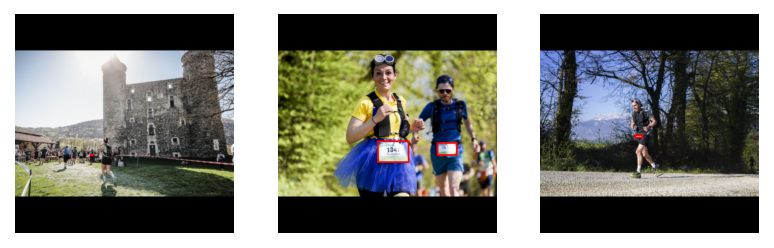

In [29]:
plt.subplot(1, 3, 1)
idx = random.randint(0, len(dataset_train)-1)
image, target = dataset_train[idx]
show_img_bbox(image, target["boxes"])

plt.subplot(1, 3, 2)
idx = random.randint(0, len(dataset_train)-1)
image, target = dataset_train[idx]
show_img_bbox(image, target["boxes"])

plt.subplot(1, 3, 3)
idx = random.randint(0, len(dataset_train)-1)
image, target = dataset_train[idx]
show_img_bbox(image, target["boxes"])



## Faster R-CNN Model

In this section, we'll load a Faster R-CNN model using the default pre-trained weights from torchvision. Faster R-CNN is a powerful object detection architecture that combines a Region Proposal Network (RPN) with a Fast R-CNN detector, enabling it to efficiently localize and classify objects in an image.

Since we're focusing on dossard detection, we only need to detect two classes:
- 1 → Dossard
- 0 → Background

We'll update the classification head of the model to reflect this specific use case.

Let’s load and adapt our model! 🧠🔍

In [16]:
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator

# Function to load the model
def get_object_detection_model(num_classes):
    weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=weights)

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

model = get_object_detection_model(num_classes=2) # dossards and background

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 179MB/s]


## Model training 🏋️‍♂️

Before starting the training process, we first check the available device -  we should have access to a GPU, as training Faster R-CNN on CPU would be very slow and inefficient.

🔧 **Training Setup**\
We’ll define:
- An optimizer (SGD) to update the model’s weights during training.
- A learning rate scheduler to adjust the learning rate dynamically for better convergence.

🔁 **Training Loop**\
The training loop works as follows:
- Loop over the specified number of epochs.
- For each epoch, iterate over the mini-batches from the training data.
- Calculate the loss and perform backpropagation to update the model weights.

⚠️ **Notes & Tips**\
If you encounter a CUDA out of memory error:
- Try reducing the batch size.
- Or restart the runtime to free up memory.

At the end of training, the parameters of the best-performing model will be saved automatically for later use.

Let’s get training! 🚀💪



In [17]:
# Check if a GPU is avalable and move the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Check device: should be "cuda:0"!!!
print(device)

cuda:0


In [18]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
opt = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)

In [19]:
# Function to get the loss per batch
def get_loss_batch(loss_dict, opt=None):
    loss = sum(loss for loss in loss_dict.values()) # Sums all individual losses (cls + bbox + RPN)

    if opt is not None: # During training!
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item()


# Function to get the loss per epoch
def loss_epoch(model, dataset_dl, device, sanity_check=False, opt=None):
    running_loss = 0.
    total_batches = len(dataset_dl)

    # Loop over batches
    for i, (images, targets) in enumerate(dataset_dl):
        # Move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        loss = get_loss_batch(loss_dict, opt)

        running_loss += loss

        if sanity_check:
            break

    epoch_loss = running_loss / (1 if sanity_check else total_batches)
    return epoch_loss


# Function to geth the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [20]:
# Main function for training and validation
def train_val(model, params):
    # Unpack parameters
    num_epochs=params["num_epochs"]
    device=params["device"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history={"train": [],"val": [],}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')

    # Main loop
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        # Training
        model.train()
        train_loss = loss_epoch(model, train_dl, device, sanity_check, opt)
        loss_history["train"].append(train_loss)
        print("train loss: %.6f" %(train_loss))

        # Evaluation
        model.train() # To return a loss_dict -> torch.no_grad() ensures its save
        with torch.no_grad():
            val_loss = loss_epoch(model, val_dl, device, sanity_check)
        loss_history["val"].append(val_loss)
        print("val loss: %.6f" %(val_loss))

        if val_loss < best_loss: # If model is doing better
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) # Restart from best weights after changing LR
            print("-"*10)

        torch.cuda.empty_cache()

    model.load_state_dict(best_model_wts)
    return model, loss_history


In [22]:
# Lets start training!
params_train={
    "num_epochs": 20,
    "optimizer": opt,
    "device": device,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": dir_out + model_name,
}

model, loss_hist = train_val(model, params_train)

Epoch 0/19, current lr=0.005
train loss: 0.474912
val loss: 0.245494
Copied best model weights!
Epoch 1/19, current lr=0.005
train loss: 0.261405
val loss: 0.168588
Copied best model weights!
Epoch 2/19, current lr=0.005
train loss: 0.219321
val loss: 0.147898
Copied best model weights!
Epoch 3/19, current lr=0.005
train loss: 0.185416
val loss: 0.140484
Copied best model weights!
Epoch 4/19, current lr=0.005
train loss: 0.161319
val loss: 0.130072
Copied best model weights!
Epoch 5/19, current lr=0.005
train loss: 0.142398
val loss: 0.131049
Epoch 6/19, current lr=0.005
train loss: 0.127943
val loss: 0.131414
Epoch 7/19, current lr=0.005
train loss: 0.128870
val loss: 0.126543
Copied best model weights!
Epoch 8/19, current lr=0.005
train loss: 0.112102
val loss: 0.131239
Epoch 9/19, current lr=0.005
train loss: 0.106718
val loss: 0.125176
Copied best model weights!
Epoch 10/19, current lr=0.005
train loss: 0.099427
val loss: 0.132024
Epoch 11/19, current lr=0.005
train loss: 0.103931


## Check the Model ✅
Now that training is complete, let’s take a closer look at how the model performed.

📉 **Training & Validation Loss**\
We’ll begin by visualizing the training and validation losses over time. Ideally, both should decrease together, indicating that the model is learning effectively without overfitting.

🔍 **Visualize Predictions**\
Next, we’ll evaluate the model on the validation set:
- We define a helper function to filter predictions based on a confidence threshold.
- Then we’ll visualize a few predictions, drawing the bounding boxes on the images to inspect the model’s performance qualitatively.

This step helps us understand how well the model has learned to detect dossards in new, unseen images.

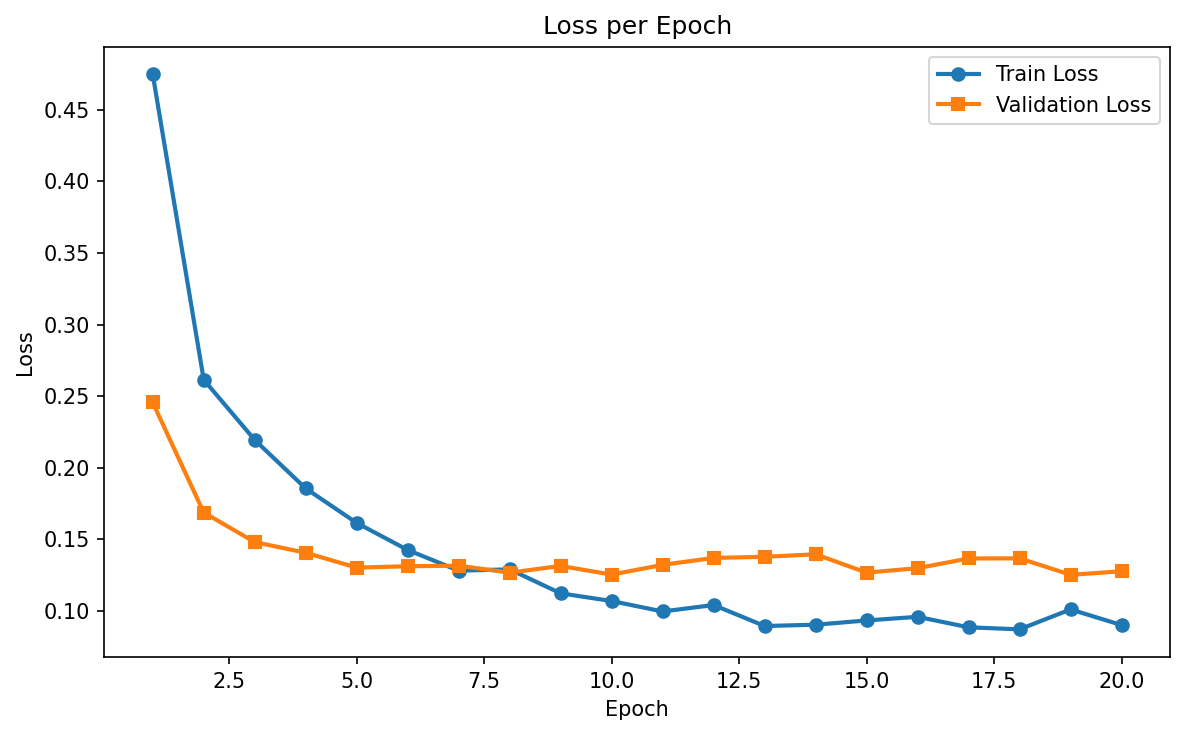

In [23]:
# plot loss_hist
epochs = range(1, len(loss_hist['train']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_hist['train'], marker='o', label='Train Loss', linewidth=2)
plt.plot(epochs, loss_hist['val'], marker='s', label='Validation Loss', linewidth=2)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Function to filter predictions by their confidence score
def filter_by_score(prediction, thresh=0.2):
  keep = prediction["scores"] >= thresh
  indices = keep.nonzero(as_tuple=True)[0]

  final_prediction = {}
  final_prediction['boxes'] = prediction['boxes'][indices]
  final_prediction['scores'] = prediction['scores'][indices]
  final_prediction['labels'] = prediction['labels'][indices]

  return final_prediction

predicted #boxes:  11
predicted #boxes after filtering:  7
real #boxes:  5


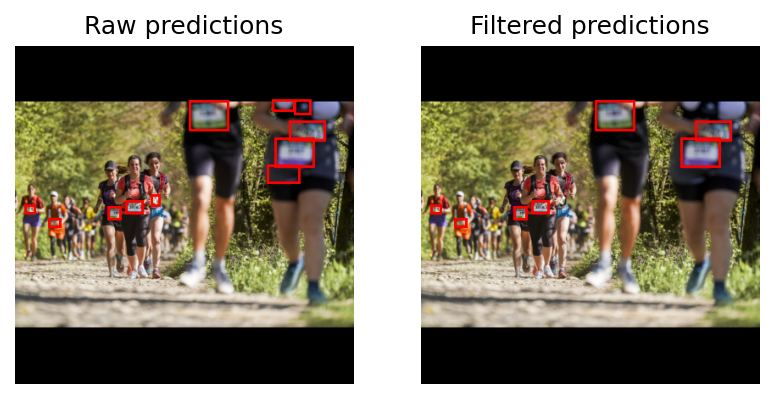

In [31]:
# pick one image from the test set
idx = random.randint(0, len(dataset_val)-1)
img, target = dataset_val[idx]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
prediction_filtered = filter_by_score(prediction) # Filter predictions by confidence score

print('predicted #boxes: ', len(prediction['labels']))
print('predicted #boxes after filtering: ', len(prediction_filtered['labels']))
print('real #boxes: ', len(target['labels']))

# Plt predictions
plt.subplot(1, 2, 1)
show_img_bbox(img, prediction["boxes"])
plt.title("Raw predictions")

plt.subplot(1, 2, 2)
show_img_bbox(img, prediction_filtered["boxes"])
plt.title("Filtered predictions")

plt.show()